# Finding Enron persons of interest from email and financial data 

In [1]:
# standard library imports
import pickle
import sys
sys.path.append("../tools/")

# package imports
from ggplot import *
import graphviz
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import scale, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# project imports
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

In [2]:
# load date and transform to dataframe 
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# As soon as you print the data frame you see the'Total' 
# row is present from the spreadsheet and needs removed
data_dict.pop('TOTAL',0)

df = pd.DataFrame.from_dict(data_dict, orient = 'index')

## Understanding the Dataset and Question

In [3]:
print "In our dataset we have:"
print 'Observations(Enron employees): %s' % df.shape[0]
print 'Features: %s' % df.shape[1]
poi_count = sum(df['poi'])
poi_percent = round(poi_count/float(df.shape[0]),4) * 100
print "With %s of them (%s%%) being persons of interest" % (poi_count, poi_percent)

In our dataset we have:
Observations(Enron employees): 145
Features: 21
With 18 of them (12.41%) being persons of interest


When we preview our dataset, it looks like there will be a lot of data missing throughout it:

In [4]:
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


 Let's get a handle on how many missing observations there are for each column:

In [5]:
def percent_missing(df, cutoff_percent = 0.):
    for col in df.columns:
        try:
            missing_percent = sum(df[col] == 'NaN')/float(df.shape[0])
            if missing_percent >= cutoff_percent:
                print col, round(missing_percent, 2)
        except:
            # This is just poi bool
            pass

percent_missing(df)

salary 0.35
to_messages 0.41
deferral_payments 0.74
total_payments 0.14
exercised_stock_options 0.3
bonus 0.44
restricted_stock 0.25
shared_receipt_with_poi 0.41
restricted_stock_deferred 0.88
total_stock_value 0.14
expenses 0.35
loan_advances 0.98
from_messages 0.41
other 0.37
from_this_person_to_poi 0.41
director_fees 0.89
deferred_income 0.67
long_term_incentive 0.55
email_address 0.23
from_poi_to_this_person 0.41


/Users/scottbrenstuhl/Projects/Data_Analyst_Nanodegree/venv/lib/python2.7/site-packages/pandas/core/ops.py:716: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


So it looks like we are missing some values in every field we have (besides poi which is not listed here) but we kind of expected as much with messy data. Let's focus on the most worysome ones.

In [6]:
percent_missing(df, .5)

deferral_payments 0.74
restricted_stock_deferred 0.88
loan_advances 0.98
director_fees 0.89
deferred_income 0.67
long_term_incentive 0.55


With these values missing in over half of observations, we might want to be cautious about how we use them. Althrough since we are hunting for very specific people that only make up 12% of the observations, some of them could be useful.

With loan_advances only appearing in 2% of the sample in a mix of pois and not, I'll be removing it.

In [7]:
df = df.drop('loan_advances',axis=1)

In [8]:
# Create a version of the dataframe with missing values filled in
df_filled = df.replace('NaN',0)
df_filled['email_address'] = df_filled['email_address'].replace(0, 'None')

Outliers are going to be tricky with this data set. I wanted to find the most agredious outliers but with so much missing data as 0s and the insanely high financial benifits some of these people were recieving, I had to go all the way up to features that have a max value seven standard deviations above the mean to focus on half the features.

It looks like most of the features with big outliers are compensation items besides normal salary and bonuses. This kind of makes sense though with there be hevily compensated execs and normal employees so we don't know that any of these are actually problematic and will have to look into them more individually.

In [9]:
# setting to not use scientific notation since that made this harder to read
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df_description = df_filled.describe()

largest_outliers = [x for x in df_description if 
                    df_description[x]['max'] > df_description[x]['mean'] + df_description[x]['std'] * 7]

df_description[largest_outliers]

,deferral_payments,total_payments,restricted_stock_deferred,total_stock_value,from_messages,other,from_this_person_to_poi,long_term_incentive
count,145.000,145.000,145.000,145.000,145.000,145.000,145.000,145.000
mean,220557.903,2243477.421,72911.572,2889718.124,361.076,295210.021,24.455,334633.986
std,751704.629,8817819.452,1297469.064,6172223.036,1445.945,1127404.270,79.527,685363.856
min,-102500.000,0.000,-1787380.000,-44093.000,0.000,0.000,0.000,0.000
25%,0.000,91093.000,0.000,221141.000,0.000,0.000,0.000,0.000
50%,0.000,916197.000,0.000,955873.000,17.000,947.000,0.000,0.000
75%,7961.000,1934359.000,0.000,2282768.000,52.000,150458.000,14.000,374347.000
max,6426990.000,103559793.000,15456290.000,49110078.000,14368.000,10359729.000,609.000,5145434.000


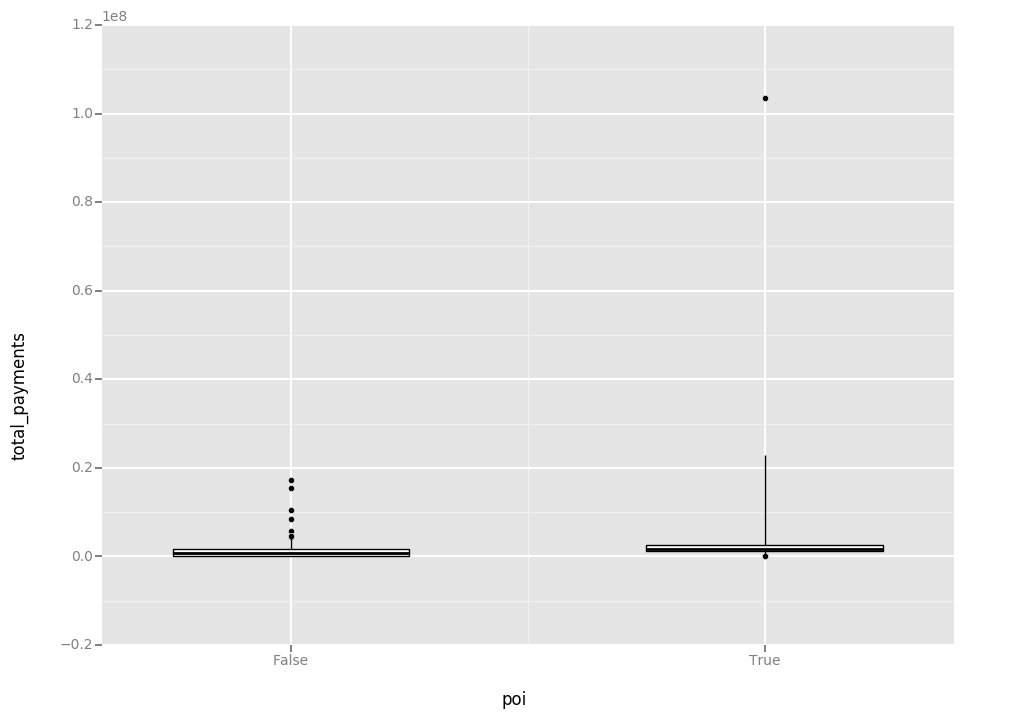

<ggplot: (287100977)>


In [10]:
# for col in df_description:
#     print ggplot(aes('poi', col), data = df_filled) +\
#             geom_boxplot()

# Example
print ggplot(aes('poi', 'total_payments'), data = df_filled) +\
            geom_boxplot()

I looked through the box-plots of the features with the largest outliers and made a list of those where the outlier seems especially far away which might be problematic (I have only printed an example above because all of them take up a large amount of space). It turns out though that most of them are Kenneth Lay whom we know made out like a bandit from the fraud so for now I will be leaving all the outliers alone.

In [11]:
aggressive_outliers = ['total_payments', 'restricted_stock', 
                        'shared_receipt_with_poi', 'restricted_stock_deferred',
                        'other']
outlier_list = []
for outlier in aggressive_outliers:
    outlier_row = df_filled[df_filled[outlier] == max(df_filled[outlier])]
    outlier_list.append({'feature' : outlier, 'person' : outlier_row.index.values[0], 'poi': outlier_row['poi'][0]})

pd.DataFrame(outlier_list)

,feature,person,poi
0,total_payments,LAY KENNETH L,True
1,restricted_stock,LAY KENNETH L,True
2,shared_receipt_with_poi,BELDEN TIMOTHY N,True
3,restricted_stock_deferred,BHATNAGAR SANJAY,False
4,other,LAY KENNETH L,True


## Optimize Feature Selection/Engineering

People that recieve a director fee seem to be different from regular company employees, they don't draw a salary or bonuses and instead are compensated in stocks and director fees. I would like to see if using director as a boolian is more informative that specific values. 

In [12]:
df['director'] = df['director_fees'] != 'NaN'
df[df['director_fees'] != 'NaN']

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person,director
BELFER ROBERT,NaN,NaN,-102500,102500,3285,NaN,NaN,NaN,44093,-44093,...,NaN,NaN,NaN,False,3285,NaN,NaN,NaN,NaN,True
BHATNAGAR SANJAY,NaN,523,NaN,15456290,2604490,NaN,-2604490,463,15456290,NaN,...,29,137864,1,False,137864,NaN,NaN,sanjay.bhatnagar@enron.com,0,True
BLAKE JR. NORMAN P,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,113784,-113784,NaN,NaN,NaN,True
CHAN RONNIE,NaN,NaN,NaN,NaN,NaN,NaN,32460,NaN,-32460,NaN,...,NaN,NaN,NaN,False,98784,-98784,NaN,NaN,NaN,True
DUNCAN JOHN H,NaN,NaN,NaN,77492,371750,NaN,NaN,NaN,NaN,371750,...,NaN,NaN,NaN,False,102492,-25000,NaN,NaN,NaN,True
GRAMM WENDY L,NaN,NaN,NaN,119292,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,119292,NaN,NaN,NaN,NaN,True
JAEDICKE ROBERT,NaN,NaN,NaN,83750,431750,NaN,44093,NaN,-44093,431750,...,NaN,NaN,NaN,False,108750,-25000,NaN,NaN,NaN,True
LEMAISTRE CHARLES,NaN,NaN,NaN,87492,412878,NaN,NaN,NaN,NaN,412878,...,NaN,NaN,NaN,False,112492,-25000,NaN,NaN,NaN,True
MENDELSOHN JOHN,NaN,NaN,NaN,148,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,103750,-103750,NaN,NaN,NaN,True
MEYER JEROME J,NaN,NaN,NaN,2151,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,38346,-38346,NaN,NaN,NaN,True


I am also making features of what percent of emails were to/from pois instead of the straight counts that we have in the data set.

In [13]:
def email_percents(poi_emails, all_emails):
    percent_emails_to_poi = []
    for from_poi, all_from in zip(df[poi_emails], df[all_emails]):
        try:
            perc_to_poi = float(from_poi)/all_from
            percent_emails_to_poi.append(round(perc_to_poi,4))
        except:
            percent_emails_to_poi.append('NaN')
    return percent_emails_to_poi

df['percent_from_emails_to_poi'] = email_percents('from_this_person_to_poi', 'from_messages')
df['percent_emails_from_poi'] = email_percents('from_poi_to_this_person', 'to_messages')

From the plots below, it looks like the percents will be a more helpful parameter since it at least gives us some decent sized areas with only non pois.

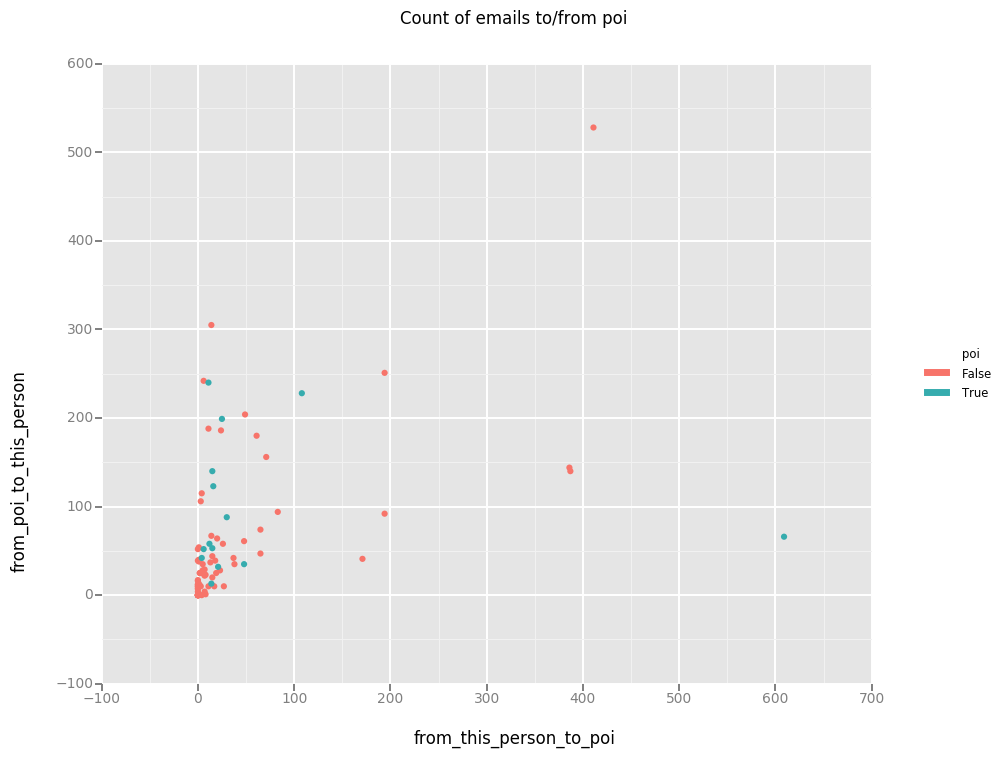

<ggplot: (287135909)>

In [14]:
ggplot(aes(x = 'from_this_person_to_poi', y = 'from_poi_to_this_person',
           color = 'poi' ), data = df ) +\
    geom_point() +\
    labs(title = "Count of emails to/from poi")

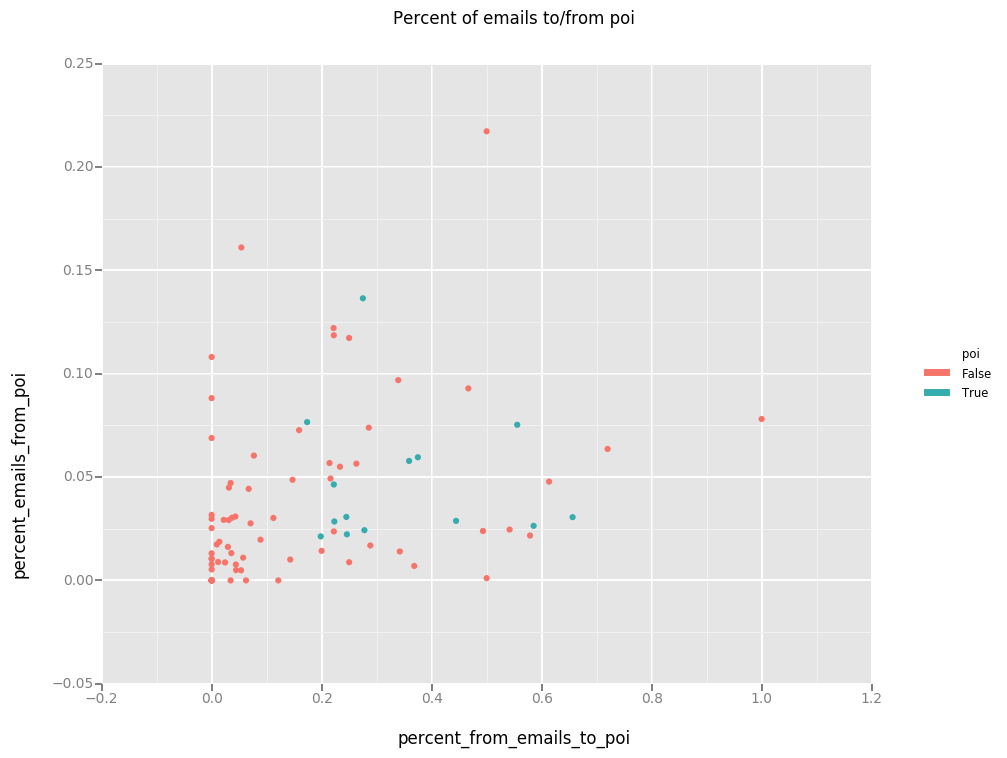

<ggplot: (287705293)>

In [15]:
ggplot(aes(x = 'percent_from_emails_to_poi', y = 'percent_emails_from_poi',
           color = 'poi' ), data = df ) +\
    geom_point()+\
    labs(title = "Percent of emails to/from poi")

I was initially concerned about the person who sent 100% of their emails to a poi, but Gene Humphrey seems to be accurate, so we won't toss it as an outlier.

In [16]:
df[df['percent_from_emails_to_poi']==1][
    ['from_this_person_to_poi', 'from_messages', 'percent_from_emails_to_poi']]

,from_this_person_to_poi,from_messages,percent_from_emails_to_poi
HUMPHREY GENE E,17,17,1.000


Now that we have created our new features lets split the test and training set.

In [17]:
# Split poi from the features
labels = df_filled['poi']
# I have relized I am not doing anything interesting with email addresses and they cause type issues
features = df_filled.drop(['poi', 'email_address'], axis=1)

features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.3, random_state=1809)

I am really interested in learning about feature selection and seeing what different results we get from different 
strategies. I started with feature importance from decision tree. 

In [18]:
dt_clf = DecisionTreeClassifier(random_state=1809)
dt_clf.fit(features_train, labels_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1809, splitter='best')

It looks like a LOT of our features are useless, but we can see that some are really useful for this approach and the drops after the 6th most important feature.

In [19]:
importance_df = pd.DataFrame({'features':features_train.columns, 'importance':dt_clf.feature_importances_})
dt_important_features = importance_df.sort_values('importance', ascending= False)['features'][0:7]
importance_df.sort_values('importance', ascending= False)

,features,importance
15,deferred_income,0.292
7,shared_receipt_with_poi,0.257
2,deferral_payments,0.132
1,to_messages,0.095
11,from_messages,0.091
13,from_this_person_to_poi,0.083
10,expenses,0.050
0,salary,0.000
16,long_term_incentive,0.000
14,director_fees,0.000


Next I want to fit a logistic regreassion and do a recusrive feature elimination. For this we need to first scale the data since we are using regression.



In [20]:
# Scale the training and testing features in a consistant way
scaler = StandardScaler().fit(features_train)
scaled_features_train = scaler.transform(features_train)
scaled_features_test = scaler.transform(features_test)

# Set up a logistic regression model and run RFE with
model = LogisticRegression()
rfe = RFE(model, 5)
rfe.fit(scaled_features_train, labels_train)

# The features that RFE has selected, to be used with mosdels later
rfe_selected = features_train.columns[rfe.support_]

# Checking the order is consistant for my own sanity
if (rfe.support_ == [x in rfe_selected for x in importance_df['features'].values]).all():
    importance_df['rfe_selected'] = rfe.support_


The recursive feature elimination has very little overlap with the top features from decision trees. Which is surprising to me, but likely has to do with the very different ways in which regression and decision trees use features. It will be interesting to see how this affects their performance with different algorithms.

In [21]:
# Compare RFE selections with decision tree importance
importance_df.sort_values('importance', ascending= False)

,features,importance,rfe_selected
15,deferred_income,0.292,True
7,shared_receipt_with_poi,0.257,False
2,deferral_payments,0.132,True
1,to_messages,0.095,False
11,from_messages,0.091,True
13,from_this_person_to_poi,0.083,True
10,expenses,0.050,False
0,salary,0.000,False
16,long_term_incentive,0.000,False
14,director_fees,0.000,False


I am also using principal component analysis(PCA) to create new principal components we can use for predictions. By plotting the variance explained by each principal component created we can see that the improvements more or less level off around the 6th component. 

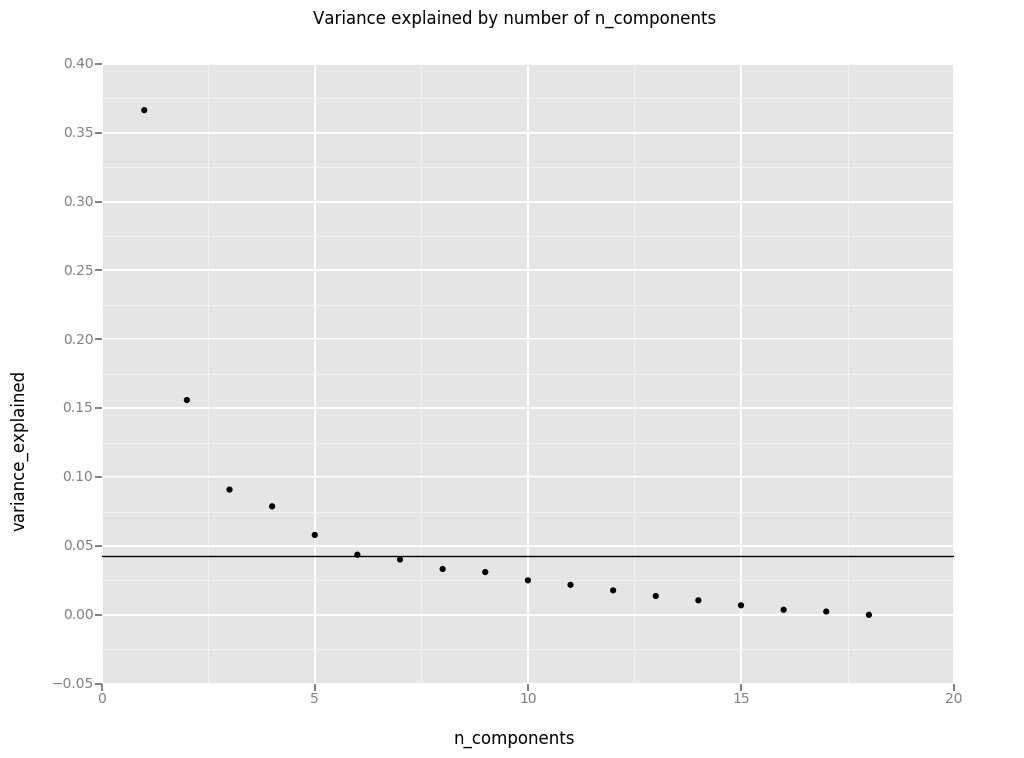

<ggplot: (287694141)>


In [22]:
# Train PCA and create the new principal components
pca = PCA(n_components=scaled_features_train.shape[1])
pca = pca.fit(scaled_features_train)

pca_explained = pca.explained_variance_ratio_
pca_explained_df = pd.DataFrame({'n_components':range(1,len(pca_explained)+1), 'variance_explained':pca_explained})

print ggplot(aes(x = 'n_components', y = 'variance_explained'), data= pca_explained_df) +\
            geom_point() +\
            labs(title = 'Variance explained by number of n_components') +\
            geom_hline(y=.043)


In [23]:
# Use the first six principal components since that is when improvements level off
pca = PCA(n_components = 6)
pca = pca.fit(scaled_features_train)

# summarize components
print("Explained Variance: %s") % pca.explained_variance_ratio_

features_train_pca = pca.transform(scaled_features_train)
features_test_pca = pca.transform(scaled_features_test)

Explained Variance: [ 0.36631985  0.15592772  0.09094319  0.07876602  0.05800147  0.04367175]


We have some really strongly correlated features in this data set, so I am also creating a version where I have removed one of the features if two features have over 75% correlation.

In [24]:
feature_count = df_filled.shape[1]+1

# Print the 10 most correlated feature sets (two for each set)
print df_filled.corr().unstack().sort_values()[-feature_count-20:-feature_count]

other                    total_stock_value         0.634
total_stock_value        other                     0.634
restricted_stock         other                     0.634
other                    restricted_stock          0.634
bonus                    from_poi_to_this_person   0.642
from_poi_to_this_person  bonus                     0.642
bonus                    salary                    0.651
salary                   bonus                     0.651
total_payments           total_stock_value         0.662
total_stock_value        total_payments            0.662
bonus                    shared_receipt_with_poi   0.666
shared_receipt_with_poi  bonus                     0.666
                         from_poi_to_this_person   0.734
from_poi_to_this_person  shared_receipt_with_poi   0.734
restricted_stock         total_stock_value         0.781
total_stock_value        restricted_stock          0.781
total_payments           other                     0.830
other                    total_

In [25]:
# Drop one of the featrures from all sets with over .75 correlation
features_less_corr_train = features_train.drop(['director_fees','to_messages',
                                                'total_payments', 'total_stock_value'], axis =1)
features_less_corr_test = features_test.drop(['director_fees','to_messages',
                                                'total_payments', 'total_stock_value'], axis =1)

# trean and set top import features for the less correlated dataframe
dt_lc_clf = DecisionTreeClassifier(random_state=1809)
dt_lc_clf.fit(features_less_corr_train, labels_train)
importance_lc_df = pd.DataFrame({'features':features_less_corr_train.columns,
                                 'importance':dt_lc_clf.feature_importances_})
dt_lc_important_features = importance_lc_df.sort_values('importance', ascending= False)['features'][0:6]
importance_lc_df.sort_values('importance', ascending= False)

# Scale the less correlated features
scaler = StandardScaler().fit(features_less_corr_train)
scaled_less_corr_features_train = scaler.transform(features_less_corr_train)
scaled_less_corr_features_test = scaler.transform(features_less_corr_test)

# Do logistic regression RFE on the less correlated features
lc_model = LogisticRegression()
lc_rfe = RFE(lc_model, 5)
lc_rfe.fit(scaled_less_corr_features_train, labels_train)

# set the features selected based on less correleated features
lc_rfe_selected = features_less_corr_train.columns[lc_rfe.support_]

importance_lc_df['lc_rfe_selected'] = lc_rfe.support_

Since we removed two of the features selected previously by decision trees, there are obviously a couple new ones in the most important list, interestingly thought the logistic regression rfe is the same features although I would have expected it to be the most affected by the correlation change.

In [26]:
# Check if RFE is the same in both feature sets
print lc_rfe_selected == rfe_selected

importance_lc_df.sort_values('importance', ascending= False)

[ True  True  True  True  True]


,features,importance,lc_rfe_selected
5,shared_receipt_with_poi,0.352,False
11,deferred_income,0.241,True
1,deferral_payments,0.132,True
8,from_messages,0.091,True
10,from_this_person_to_poi,0.083,True
0,salary,0.051,False
7,expenses,0.050,False
2,exercised_stock_options,0.000,False
3,bonus,0.000,True
4,restricted_stock,0.000,False


In [27]:
# Make scaled featues DataFrames for consistency and feature selection below
scaled_less_corr_features_train = pd.DataFrame(scaled_less_corr_features_train,
                                               columns=features_less_corr_train.columns)
scaled_less_corr_features_test = pd.DataFrame(scaled_less_corr_features_test, 
                                              columns=features_less_corr_test.columns)
scaled_features_train = pd.DataFrame(scaled_features_train, columns=features_train.columns)
scaled_features_test = pd.DataFrame(scaled_features_test, columns=features_test.columns)

### Pick and Tune an Algorithm

We have some parameters to work with now so lets see how they perform with different Algorithms!

In [28]:
algos_tried = []

def cross_val_scores(clf, features, labels, cv=20):
    '''cross validate for accuracy, precision, recall, 
    and amount of 0s in precision and recall.'''
    zeros = 0
    accuracy_scores = cross_val_score(clf, features, labels, cv=cv)
    mean_accuracy = 1.0* sum(accuracy_scores)/len(accuracy_scores)
    precision_scores = cross_val_score(clf, features, labels,
                                       cv=cv, scoring= 'precision')
    mean_precision = 1.0* sum(precision_scores)/len(precision_scores)
    recall_scores = cross_val_score(clf, features, labels,
                                       cv=cv, scoring= 'recall')
    mean_recall = 1.0* sum(recall_scores)/len(recall_scores)
    all_scores = np.concatenate([precision_scores,recall_scores])
    for score in all_scores:
        if score == 0:
            zeros += 1
    perc_zeros = 1.*zeros/len(all_scores)
    return (mean_accuracy, mean_precision, mean_recall, perc_zeros, zeros) 
  
def classifier(classifier, features, labels, algo_name, data_used, less_corr, scaled):
    '''fit and cross validate algorithem passed to it and 
    append results to algos_tried'''
    try:
        clf = classifier(random_state = 1809)
    except:
        clf = classifier()
    clf.fit(features, labels)
    scores = cross_val_scores(clf, features, labels)
    algo_tried = {'algo': algo_name,
                  'data_used': data_used,
                  'accuracy' : scores[0],
                  'precision' : scores[1],
                  'recall': scores[2],
                  'less_corr': less_corr,
                  'scaled': scaled,
                  'perc_zeros': scores[3]}
    algos_tried.append(algo_tried)
    
def test_all_datasets(clf, algo, scaled = False):
    '''Try an algorithm with all of the datasets that have 
    been prepared and append the results to algos_tried'''
    if scaled:
        train_features = scaled_features_train
        train_less_corr = scaled_less_corr_features_train
    else:
        train_features = features_train
        train_less_corr = features_less_corr_train
    classifier(clf, train_features, labels_train, algo, 'All', False, scaled) 
    classifier(clf, train_less_corr, labels_train,
               algo, 'All Less Corr', True, scaled) 
    classifier(clf, train_features[dt_important_features], labels_train, 
               algo, 'DT Important', False, scaled) 
    classifier(clf, train_less_corr[dt_lc_important_features], labels_train,
               algo, 'DT Important', True, scaled)
    classifier(clf, train_features[rfe_selected], labels_train,
               algo, 'RFE Selected', False, scaled)
    classifier(clf, features_train_pca, labels_train,
               algo, 'PCA features', False, True) 

In [29]:
# Test each of the ml algos we went over in the course with default values
test_all_datasets(GaussianNB, 'Naive Bayes', False)
test_all_datasets(SVC, 'SVM', True)
test_all_datasets(DecisionTreeClassifier, 'DT', False)
test_all_datasets(RandomForestClassifier, 'Random Forest', False)
test_all_datasets(AdaBoostClassifier, 'AdaBoost', False)

/Users/scottbrenstuhl/Projects/Data_Analyst_Nanodegree/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 11 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=20.
  % (min_labels, self.n_folds)), Warning)
/Users/scottbrenstuhl/Projects/Data_Analyst_Nanodegree/venv/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/scottbrenstuhl/Projects/Data_Analyst_Nanodegree/venv/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Now we have a tidy data frame of the algorithms we tried, what data they used, and their cross validated accuracy, precision, and recall. In earlier iterations of this exploration I was having problems with some performing well and then bombing on other data sets and I realized it is because they fit some perfectly but scored 0 on a lot of samples. Due to this I made the perc_zeros field which tells how many of the precision and recall scores were a zero in the cross validation. We can consider those that score high in this field worth approaching with caution.

In [30]:
algos_tried_df = pd.DataFrame.from_dict(algos_tried)
algos_tried_df

,accuracy,algo,data_used,less_corr,perc_zeros,precision,recall,scaled
0,0.551,Naive Bayes,All,False,0.650,0.158,0.350,False
1,0.584,Naive Bayes,All Less Corr,True,0.700,0.138,0.300,False
2,0.853,Naive Bayes,DT Important,False,0.950,0.050,0.050,False
3,0.853,Naive Bayes,DT Important,True,0.950,0.050,0.050,False
4,0.857,Naive Bayes,RFE Selected,False,0.900,0.100,0.100,False
5,0.863,Naive Bayes,PCA features,False,0.950,0.050,0.050,True
6,0.907,SVM,All,False,1.000,0.000,0.000,True
7,0.907,SVM,All Less Corr,True,1.000,0.000,0.000,True
8,0.907,SVM,DT Important,False,1.000,0.000,0.000,True
9,0.907,SVM,DT Important,True,1.000,0.000,0.000,True


After running all of the algorithms I selected there is a lot to look at! Unfortunately our SVM's best fit with all data sets was to return false for all predictions, this gave it decent accuracy since people of interest are fairly rare... but it's completely useless to us. Let's focus on the best performers.

In [31]:
algos_tried_df.loc[[0,15,20,27]]

,accuracy,algo,data_used,less_corr,perc_zeros,precision,recall,scaled
0,0.551,Naive Bayes,All,False,0.650,0.158,0.350,False
15,0.890,DT,DT Important,True,0.700,0.250,0.300,False
20,0.890,Random Forest,DT Important,False,0.850,0.150,0.150,False
27,0.871,AdaBoost,DT Important,True,0.800,0.175,0.200,False


The Naive Bayes results got 0 precision and recall the most infrequently, but it's accuracy was only 55% in a situation where saying not poi gets it right almost 90% of the time, it does have decent recall though. This means that it is claiming many of the people are a POI when they are not, this might be fine if we have plenty of bandwidth to investigate a lot of false leads.

I kind of like the decision tree better for this situation though, unlike the others strategies we can easily understand why it is making the decisions it is making. This could be invaluable in an investigation because we could look at why people are being picked as a poi and decide if it makes sense to investigate them further. For example, we might see that Kenneth Lay's executive assistant gets tagged as a poi because of a high percent of emails to them from other pois but we would expect them to receive a lot of emails from Kenneth Lay.

I also think that random forest may be limited by the amount of trees it uses in the default settings (10) so I am interested in trying to tune both a decision tree model and a random forest.

In [32]:
# Set all of the decision tree parameters to try
parameters = {'criterion':('gini', 'entropy'),
              'max_features':['auto', 'sqrt', 'log2'],
              'max_depth':[None,1,2,4],
              'min_samples_leaf':[1,2,3,4],
              'min_samples_split':[1,2,4,10,15,20,25]}

# Create the classifier
dt_clf = DecisionTreeClassifier(random_state=1809)

# Grid search all the parameters passed above
# cv =15 is overfit
tune_clf = GridSearchCV(dt_clf, parameters, scoring = 'f1', cv = 15)
tune_clf.fit(features_train[dt_important_features], labels_train)

# print the classifier so that I can put it in poi_id
tune_clf.best_estimator_

/Users/scottbrenstuhl/Projects/Data_Analyst_Nanodegree/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 11 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=15.
  % (min_labels, self.n_folds)), Warning)
/Users/scottbrenstuhl/Projects/Data_Analyst_Nanodegree/venv/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/scottbrenstuhl/Projects/Data_Analyst_Nanodegree/venv/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1809, splitter='best')

To be honest it's pretty dissapointing that this didn't perform well on the holdout set :/ At first its not entirely surprising though since so many of the exploratory cross validations had 0 for accuracy and/or precision.

In [33]:
pred = tune_clf.predict(features_test[dt_important_features])
print 'test accuracy:', round(accuracy_score(labels_test, pred), 3)
print 'test precision:', round(precision_score(labels_test, pred), 3)
print 'test recall:', recall_score(labels_test, pred)

test accuracy: 0.682
test precision: 0.111
test recall: 0.142857142857


If we also look at that evaluations on the train data though, it looks like our model is probably overfit. 

In [34]:
pred = tune_clf.predict(features_train[dt_important_features])
print 'train accuracy:', round(accuracy_score(labels_train, pred), 3)
print 'train precision:', round(precision_score(labels_train, pred), 3)
print 'train recall:', recall_score(labels_train, pred)

train accuracy: 0.941
train precision: 0.667
train recall: 0.909090909091


Looking at the decision tree really drives this point home since there are so many branches!

FEATURE KEY
-----------
X[0] : deferred_income
X[1] : shared_receipt_with_poi
X[2] : deferral_payments
X[3] : to_messages
X[4] : from_messages
X[5] : from_this_person_to_poi


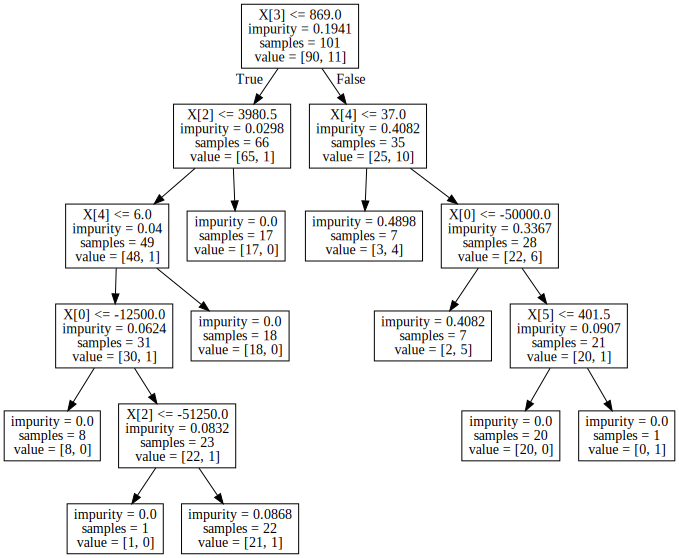

In [35]:
# Create a key for what features map to numbers in the tree graph
print "FEATURE KEY"
print "-----------"
for n in range(0,len(features_test[dt_important_features].columns)):
    print "X[%s] : %s" % (n, features_test[dt_important_features].columns[n])

# Export visualization of the tree
export_graphviz(tune_clf.best_estimator_.tree_, out_file="tuned_tree.dot")

# Open tree viz and display it
with open("tuned_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

I have tried cranking the cross validation in the gridsearch function from 15 all the way up to 50 to see if it's possible to combat this overfitting in our tuned model, unfortunately no dice though (I returned it to 15 to speed up anyone's attempts to recreate this). I believe this to be an issue with 

In [36]:
# Display model to use in poi_id.py
print ['poi']+[x for x in dt_important_features]
tune_clf.best_estimator_

['poi', 'deferred_income', 'shared_receipt_with_poi', 'deferral_payments', 'to_messages', 'from_messages', 'from_this_person_to_poi']


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1809, splitter='best')

In [37]:
rf_clf = RandomForestClassifier(random_state = 1809)
rf_clf.fit(features_train[dt_important_features], labels_train)
rf_pred = rf_clf.predict(features_test[dt_important_features])


param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Create the classifier
rf_clf = RandomForestClassifier(random_state=1809, n_estimators=20)

# Grid search all the parameters with the 
# This works really well
clf = GridSearchCV(rf_clf, parameters, scoring = 'f1', cv = 10)
clf.fit(features_train[dt_important_features], labels_train)
pred = clf.predict(features_test[dt_important_features])


print 'accuracy:', round(accuracy_score(labels_test, pred), 3)
print 'precision:', round(precision_score(labels_test, pred), 3)
print 'recall:', recall_score(labels_test, pred)

tune_clf.best_estimator_

accuracy: 0.841
precision: 0.0
recall: 0.0


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1809, splitter='best')

In [38]:
print clf.best_estimator_

tuned_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=1809, verbose=0,
            warm_start=False)

tuned_clf.fit(features_train[dt_important_features], labels_train)
pred = tune_clf.predict(features_test[dt_important_features])
print 'accuracy:', round(accuracy_score(labels_test, pred), 3)
print 'precision:', round(precision_score(labels_test, pred), 3)
print 'recall:', recall_score(labels_test, pred)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=1809, verbose=0,
            warm_start=False)
accuracy: 0.682
precision: 0.111
recall: 0.142857142857


need to add scaling back for pca http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#the-effect-of-standardization-on-pca-in-a-pattern-classification-task

No scaling for NB https://discussions.udacity.com/t/how-does-naivebayes-contain-feature-scaling-by-design/194044/3

The random forest model with all data is also tied for highest accuracy, but was right 100% of the time it predicted the person to be a poi, it also made incorrect predictions more often though. This is a good contender for best algorithm if we are planning to just look closer at the people it predicts to be a poi. We may waste a lot of time researching bad leads though since it incorrectly predicts poi so often.

My main questions:
- When I change the random_state in my train_test_split I get drastically different results for recall, f1, and precision. Does this imply I am overfitting my model or is it something else I am missing. (the model seems to perform well when cross validated).
- If it is overfitting, what sort of things should I look into for avoiding it? I have tried using a high cross validation when doing gridsearchCV, which helps a little but the issue still happens. Outlier removal? Using less correlated features?
- With such a small dataset, would it make sense to just train on all of the data and cross validate on it... this doesnt seem ideal but maybe it's the best option since the data is so limited. 
- I originally created a loop that tried the default version of SVM, Decision Tree, Random Forest, AdaBoost, etc. Then picked a couple I liked and tuned them. However Im seeing now that if I slightly change the size of my test train split or change the random state, it gives completely different results. So this is obviously a bad way to investigate them.
- Do you expect you test results to vary drastically from the cross validated results?

What if I increase sample size with the cv increase? 

 
Usual way to tell if overfit is look at "training error" train on training set and test on training set you should get a high score. but then if on the testing set you would know its overfitting 

Try 3 or 4 and compare against cross validations score. Best to do against just the training set.

for cross validation you can have it return f1 or recall 

In [39]:
clf = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1809, splitter='best')

scores = cross_val_score(clf, features_train, labels_train, cv=10, scoring= 'accuracy')

In [40]:
print 1.0* sum(scores)/len(scores)
scores

0.871818181818


array([ 0.81818182,  0.9       ,  0.9       ,  0.8       ,  0.9       ,
        1.        ,  0.9       ,  0.8       ,  0.8       ,  0.9       ])

In [41]:
def cross_val_scores(clf, features, labels, cv=10):
    accuracy_scores = cross_val_score(clf, features, labels, cv=cv)
    mean_accuracy = 1.0* sum(accuracy_scores)/len(accuracy_scores)
    precision_scores = cross_val_score(clf, features, labels,
                                       cv=cv, scoring= 'precision')
    mean_precision = 1.0* sum(precision_scores)/len(precision_scores)
    recall_scores = cross_val_score(clf, features, labels,
                                       cv=cv, scoring= 'recall')
    mean_recall = 1.0* sum(recall_scores)/len(recall_scores)
    return (mean_accuracy, mean_precision, mean_recall)
    
    
cross_val_scores(clf, features_train, labels_train)
    
    
    
    
    

(0.87181818181818183, 0.18333333333333332, 0.29999999999999999)